In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

We are going to do time series analysis and forecasting for furniture sales.

In [2]:
df = pd.read_excel("Sample - Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

We have a good 4-year furniture sales data. 

In [3]:
furniture['Order Date'].min()

Timestamp('2014-01-06 00:00:00')

In [4]:
furniture['Order Date'].max()

Timestamp('2017-12-30 00:00:00')

## Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [5]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

In [6]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [7]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [8]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


## Indexing with time series data

In [9]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [10]:
y = furniture['Sales'].resample('MS').mean()

Have a quick peek 2017 sales data.

In [11]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## Visualizing furniture sales time series data

In [44]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(y=y, mode="lines"))
fig.update_layout(autosize=False, width=900, height=480, xaxis_title="Order Date")
fig.show()

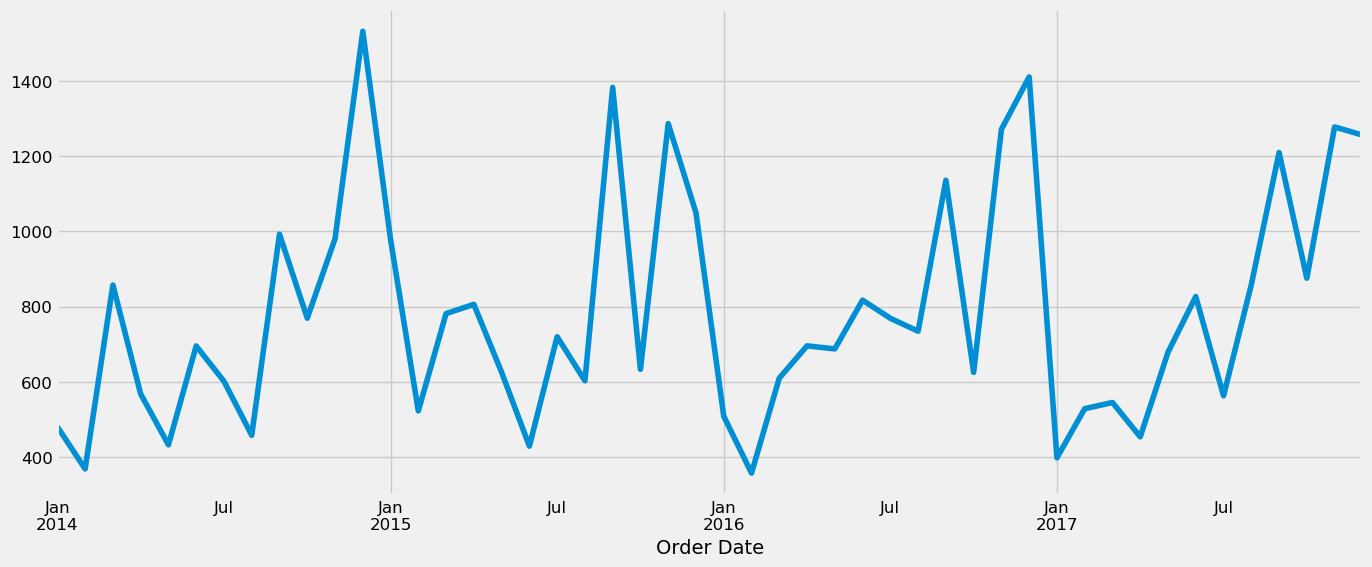

In [12]:
# y.plot(figsize=(15, 6))
# plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always a strong upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

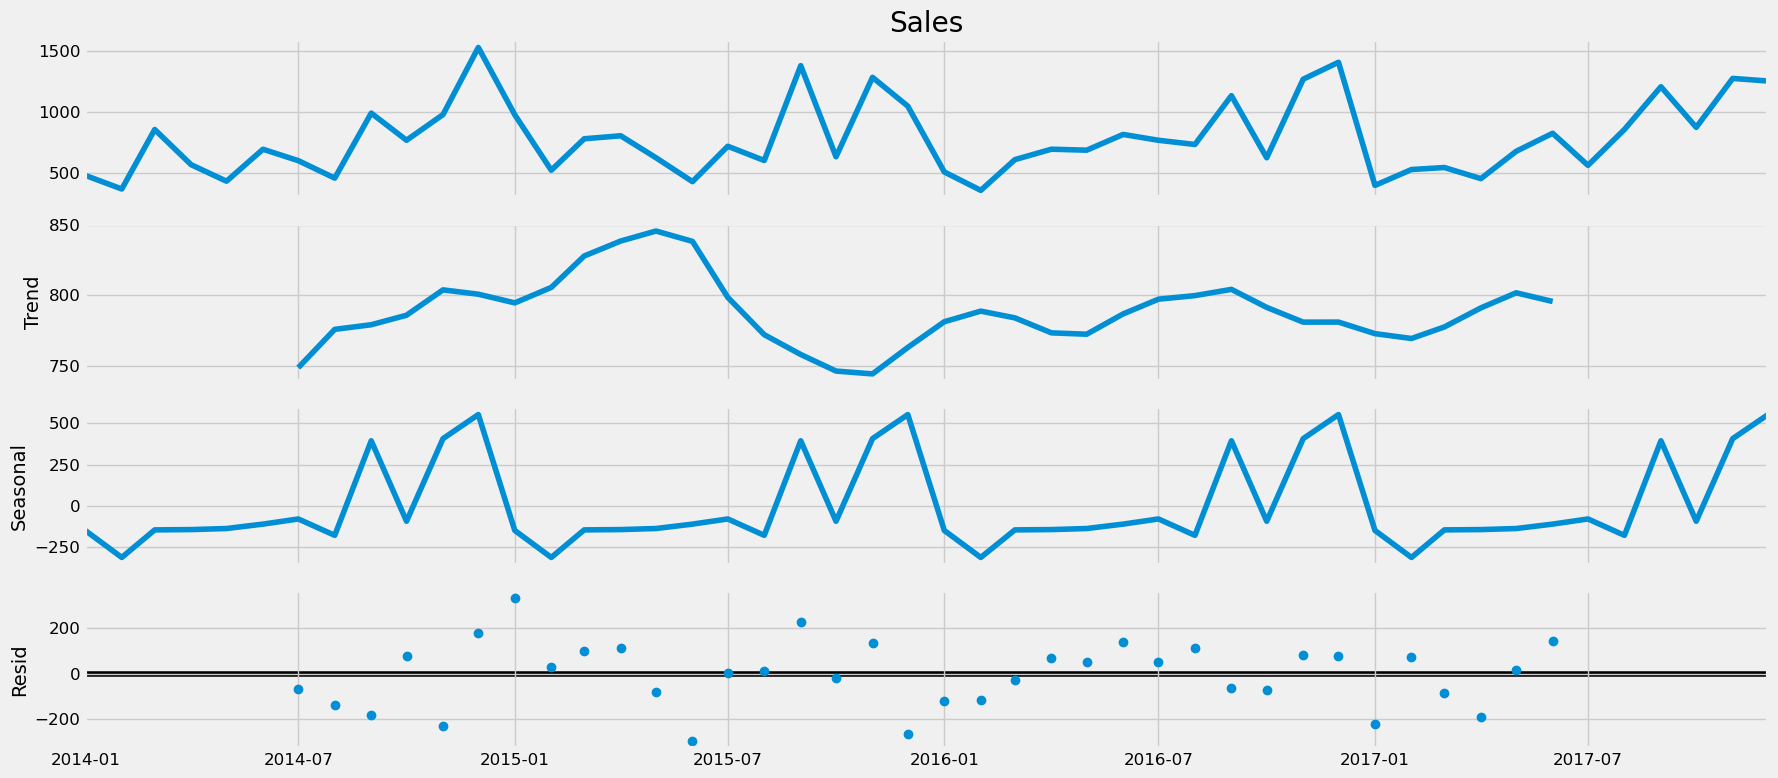

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

## Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model

In [14]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [15]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99048D+00    |proj g|=  1.66962D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   2.398D-07   7.990D+00
  F =   7.9904349200061615     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/ahmedmostafa/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/ahmedmostafa/m

  ys=-2.200E+05  -gs= 1.206E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     27      2     1     0   8.425D+04   2.746D+01
  F =   27.457579512451659     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2641.9276331953592
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.81850D+00    |proj g|=  1.63640D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function

/Users/ahmedmostafa/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/Users/ahmedmostafa/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/Users/ahmedmostafa/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M


At iterate   30    f=  2.95701D+00    |proj g|=  2.86060D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     45      1     0     0   8.000D-06   2.957D+00
  F =   2.9570058088752318     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.87255765202224
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.04097D+00    |proj g|=  1.08020D-04

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/ahmedmostafa/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     23      1     0     0   1.285D-05   6.728D+00
  F =   6.7281835175176781     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71101D+01    |proj g|=  7.20152D-03
  ys=-1.098E+05  -gs= 3.734E-02 BFGS update SKIPPED
  ys=-8.873E+03  -gs= 4.101E+02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva

/Users/ahmedmostafa/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/ahmedmostafa/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     94      4     1     0   3.385D+05   2.409D+01
  F =   24.091884328626577     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2320.8208955481514
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23022D+00    |proj g|=  3.65785D-02

At iterate    5    f=  3.22401D+00    |proj g|=  7.08917D-02

At iterate   10    f=  3.21896D+00    |proj g|=  1.01148D-03

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.4632147852136
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16805D+00    |proj g|=  1.64266D-01

At iterate    5    f=  3.14466D+00    |proj g|=  1.77769D-03

At iterate   10    f=  3.14134D+00    |proj g|=  3.70899D-02

At iterate   15    f=  3.10841D+00    |proj g|=  4.52845D-02

At iterate   20    f=  3.10633D+00    |proj g|=  1.63025D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     24      1     0     0   1.291D-


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/ahmedmostafa/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/ahmedmostafa/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 


At iterate   25    f=  3.10013D+00    |proj g|=  7.09178D-02

At iterate   30    f=  3.08947D+00    |proj g|=  1.52009D-02
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:304.58426921438394

At iterate   35    f=  3.08942D+00    |proj g|=  3.72400D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     42      1     0     0   3.724D-06   3.089D+00
  F =   3.0894194709831662     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.
/Users/ahmedmostafa/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


  ys=-5.042E+01  -gs= 8.430E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5     61      2     1     0   7.941D+04   2.505D+01
  F =   25.048485326110622     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2414.6545913066197
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15364D+00    |proj g|=  6.09532D-02

At iterate    5    f=  3.14852D+00    |proj g|=  6.15364D-03

At iterate   10    f=  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/ahmedmostafa/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  2.95838D+00    |proj g|=  1.12255D-01

At iterate   40    f=  2.95575D+00    |proj g|=  5.62662D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     56      1     0     0   1.066D-05   2.956D+00
  F =   2.9557429043112751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:293.7513188138824
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.95053D+00    |proj g|=  5.79288D-06

           * *

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/ahmedmostafa/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10197D+00    |proj g|=  1.68835D-02

At iterate    5    f=  3.10136D+00    |proj g|=  1.04559D-02

At iterate   10    f=  3.08543D+00    |proj g|=  1.26873D-01

At iterate   15    f=  3.06903D+00    |proj g|=  1.52922D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     19      1     0     0   3.073D-06   3.069D+00
  F =   3.0690321889014673     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1,

/Users/ahmedmostafa/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/Users/ahmedmostafa/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g resto


At iterate   10    f=  2.92293D+00    |proj g|=  1.02711D-03

At iterate   15    f=  2.92057D+00    |proj g|=  3.20002D-02

At iterate   20    f=  2.87973D+00    |proj g|=  3.06134D-02

At iterate   25    f=  2.84939D+00    |proj g|=  4.57849D-02

At iterate   30    f=  2.84778D+00    |proj g|=  1.98116D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     42      1     1     0   2.277D-06   2.848D+00
  F =   2.8477843822285500     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:281.3873006939408
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.


In [16]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09103D+00    |proj g|=  3.72719D-02

At iterate    5    f=  3.08056D+00    |proj g|=  3.47745D-02

At iterate   10    f=  3.07783D+00    |proj g|=  1.16849D-03
  ys=-2.589E-04  -gs= 2.696E-04 BFGS update SKIPPED

At iterate   15    f=  3.07434D+00    |proj g|=  9.55769D-04

At iterate   20    f=  3.07399D+00    |proj g|=  2.28349D-02

At iterate   25    f=  3.04254D+00    |proj g|=  2.03786D-01

At iterate   30    f=  3.01863D+00    |proj g|=  1.38227D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

 This problem is unconstrained.


In [17]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1600x800 with 0 Axes>

## Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017-07-01 to the end of the data.

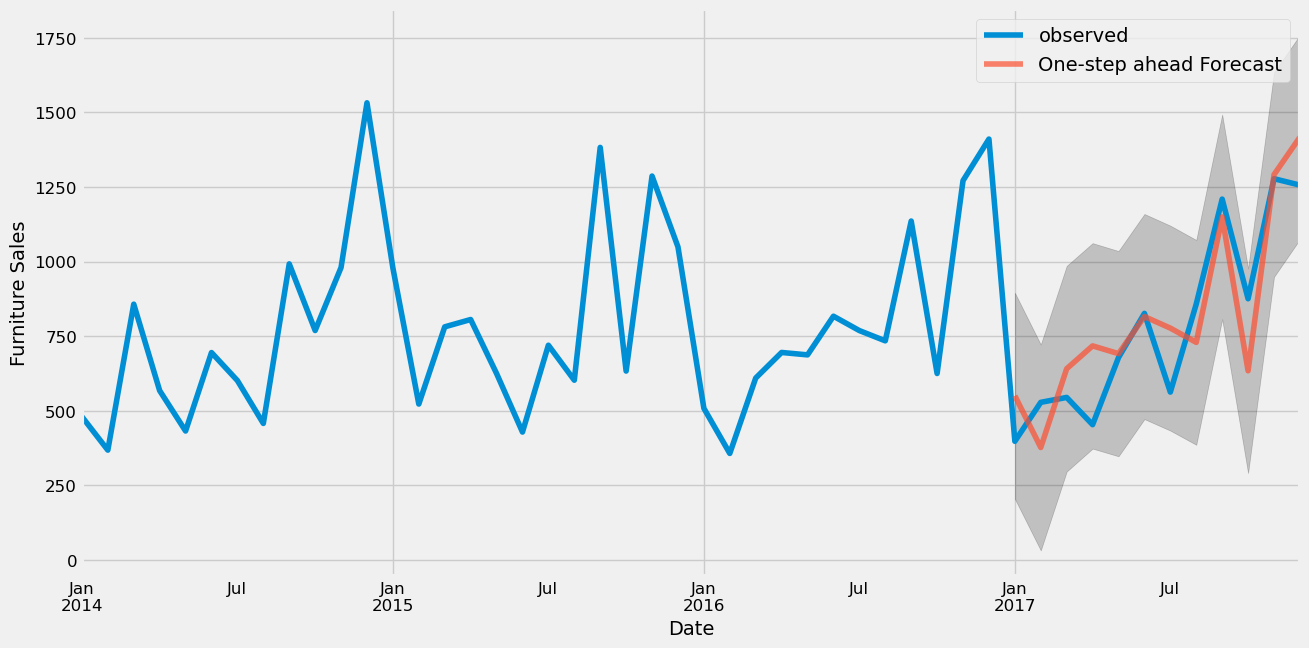

In [19]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

In [20]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.57


In [21]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

## Producing and visualizing forecasts

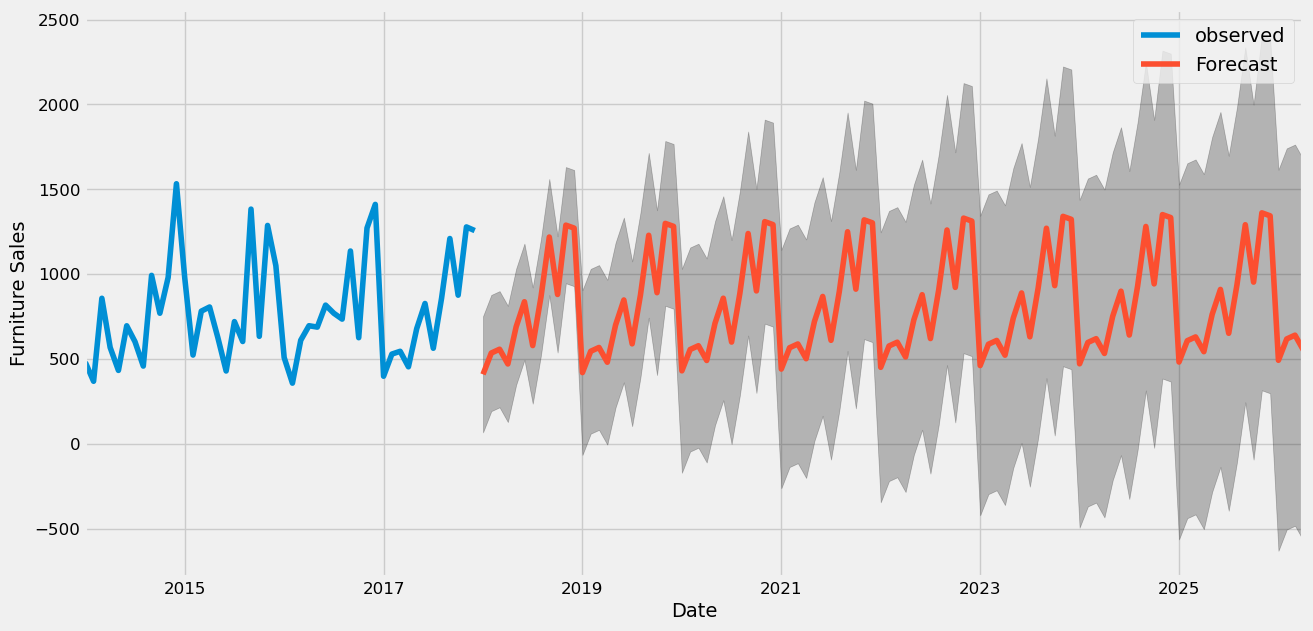

In [22]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

The above time series analysis for furniture makes me curious about other categories, and how do they compare with each other onver time. Therefore, we are going to compare time series of furniture and office supplier.

## Time Series comparison furniture sales and Office Supplies

### Data Preprocessing

In [23]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']

According to our data, there were way more number of sales from Office Supplies than from Furniture over the years.

In [24]:
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [25]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

Have a quick peek, perfect!

In [26]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


In [27]:
office.head()

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,685.340
4,2014-01-07,10.430


### Data exploration

We are going to compare two categories' sales in the same time period. This means combine two data frames into one and plot these two categories' time series into one plot.

In [28]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


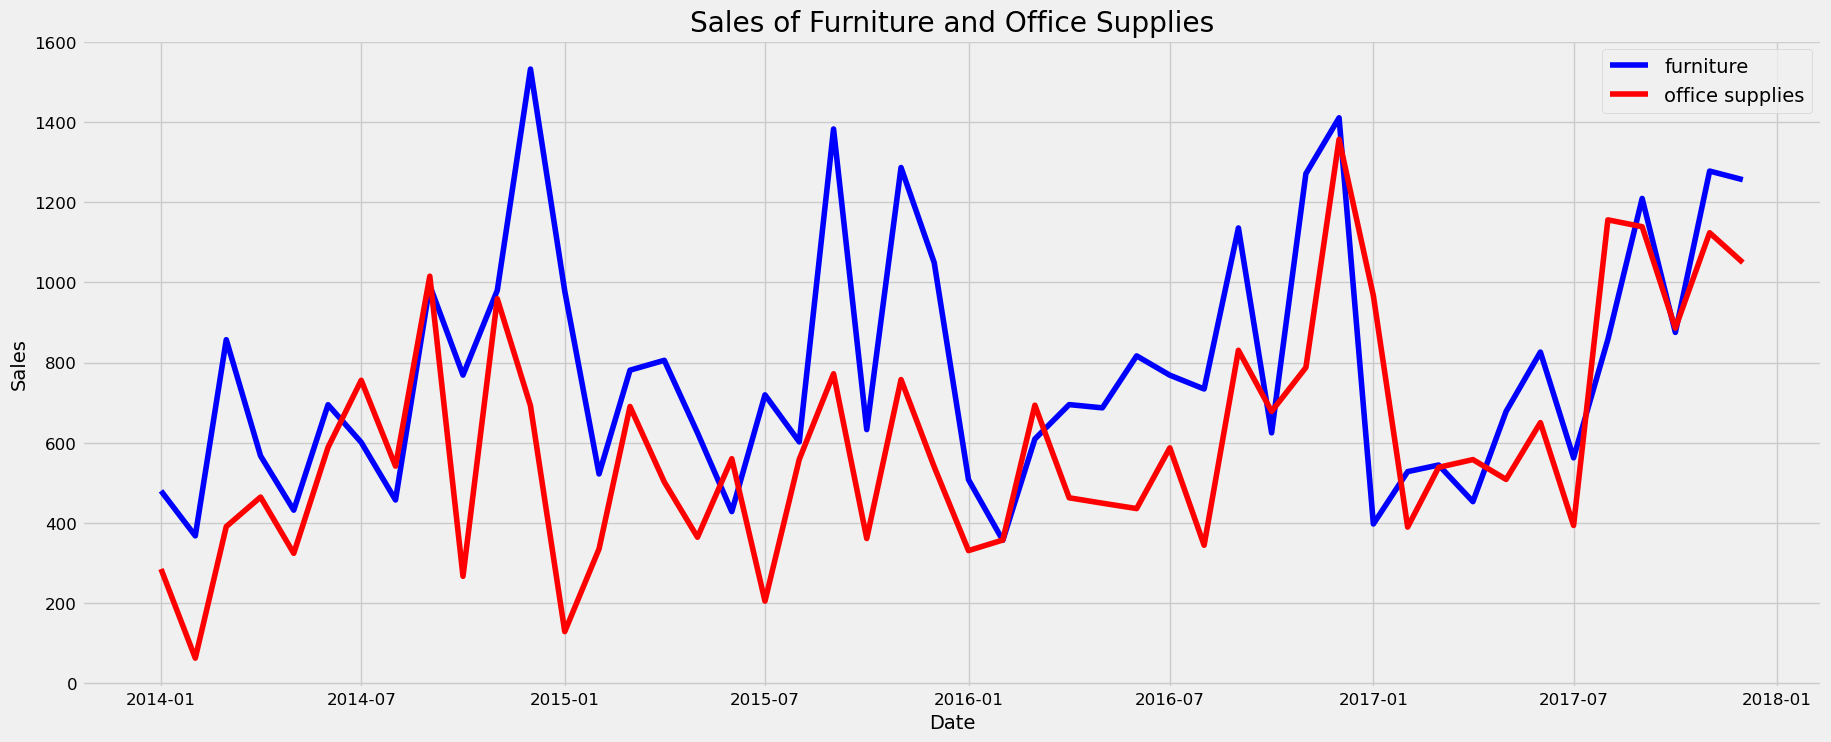

In [29]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

We observe that sales of furniture and office supplies shared a similar seasonal pattern. Early of the year is the off season for both of the two categories. It seems summer time is quiet for office supplies too. in addition, average daily sales for furniture are higher than those of office supplies in most of the months. It is understandable, as the value of furniture should be much higher than those of office supplies. Occationaly, office supplies passed furnitue on average daily sales. Let's find out when was the first time office supplies' sales surpassed those of furniture's. 

In [31]:
first_date = store.loc[
    np.min(list(np.where(store["office_sales"] > store["furniture_sales"])[0])),
    "Order Date",
]

print(
    "Office supplies first time produced higher sales than furniture is {}.".format(
        first_date.date()
    )
)

Office supplies first time produced higher sales than furniture is 2014-07-01.


It was July 2014.

### Time Series Modeling with Prophet

Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

In [34]:
from prophet import Prophet

furniture = furniture.rename(columns={"Order Date": "ds", "Sales": "y"})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={"Order Date": "ds", "Sales": "y"})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

16:46:32 - cmdstanpy - INFO - Chain [1] start processing
16:46:32 - cmdstanpy - INFO - Chain [1] done processing
16:46:32 - cmdstanpy - INFO - Chain [1] start processing
16:46:33 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

<Figure size 1800x600 with 0 Axes>

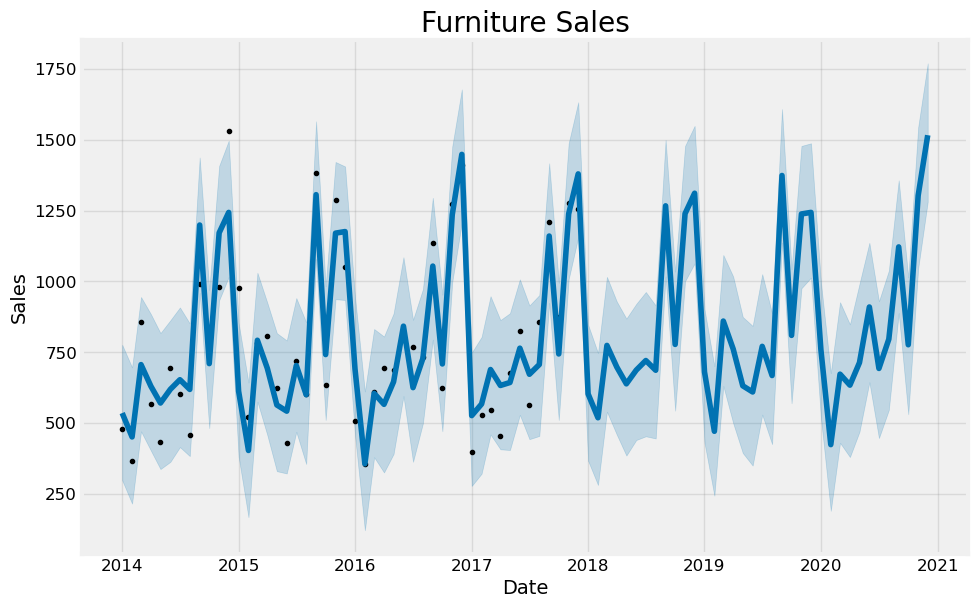

In [36]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1800x600 with 0 Axes>

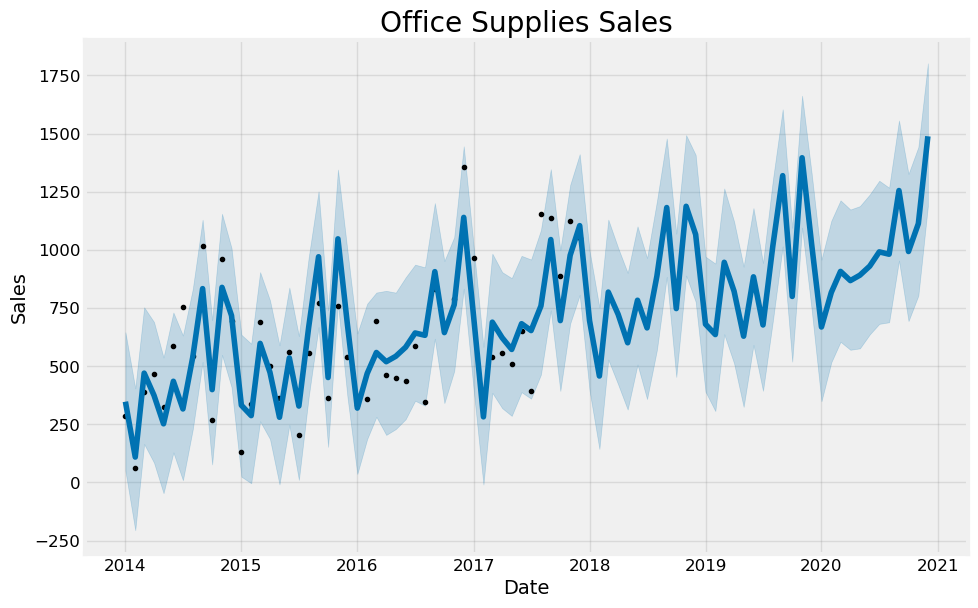

In [37]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

### Compare Forecasts

We already have the forecasts for three years for these two categories into the future. We will now join them together to compare their future forecasts.

In [38]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')

forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.058109,298.218993,776.386754,726.058109,726.058109,-190.686099,-190.686099,-190.686099,-190.686099,...,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,0.0,0.0,0.0,347.489370
1,2014-02-01,727.494421,215.876797,696.396703,727.494421,727.494421,-276.379157,-276.379157,-276.379157,-276.379157,...,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,0.0,0.0,0.0,109.240405
2,2014-03-01,728.791734,470.825378,944.869116,728.791734,728.791734,-22.388253,-22.388253,-22.388253,-22.388253,...,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,0.0,0.0,0.0,470.212385
3,2014-04-01,730.228046,402.894235,884.357162,730.228046,730.228046,-100.140909,-100.140909,-100.140909,-100.140909,...,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,0.0,0.0,0.0,374.687928
4,2014-05-01,731.618025,337.759385,817.606175,731.618025,731.618025,-160.818882,-160.818882,-160.818882,-160.818882,...,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,0.0,0.0,0.0,252.304409


### Visualizing the trend and the forecast

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


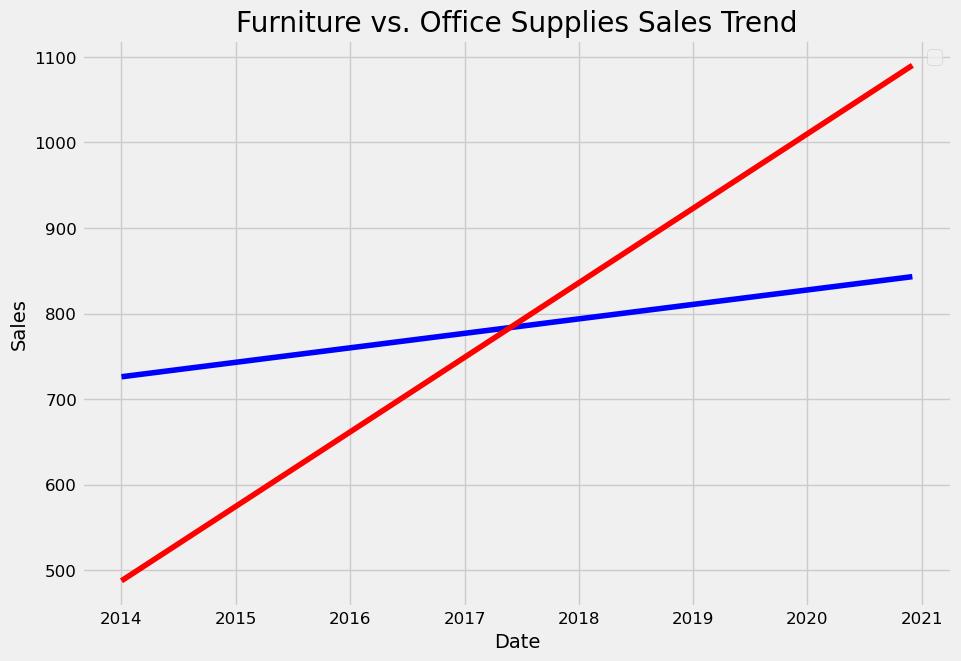

In [39]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


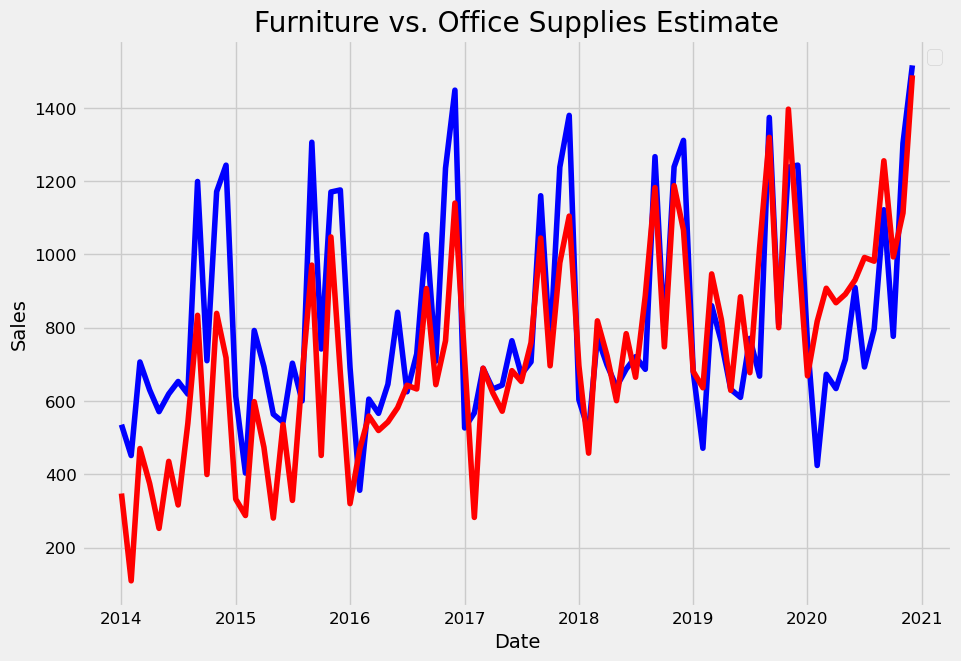

In [40]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

### Trends and Patterns

Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

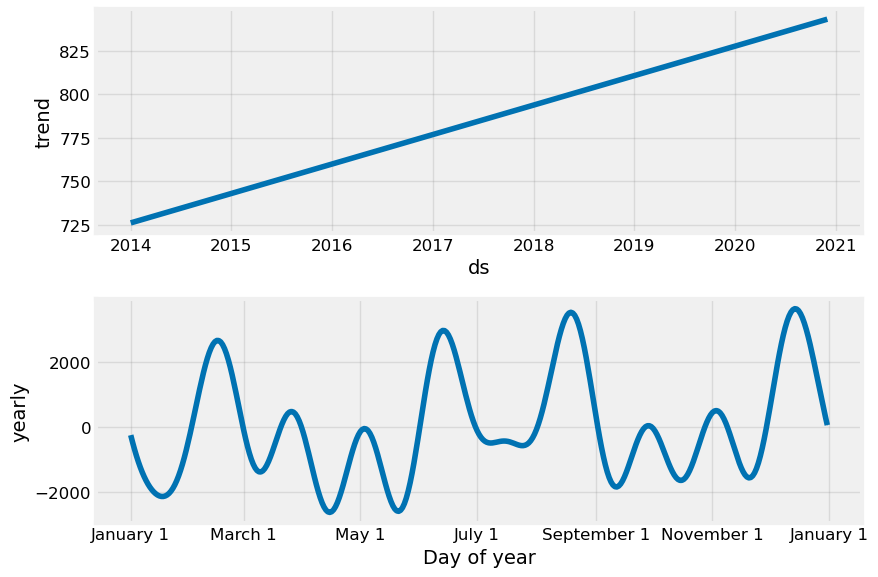

In [41]:
furniture_model.plot_components(furniture_forecast);

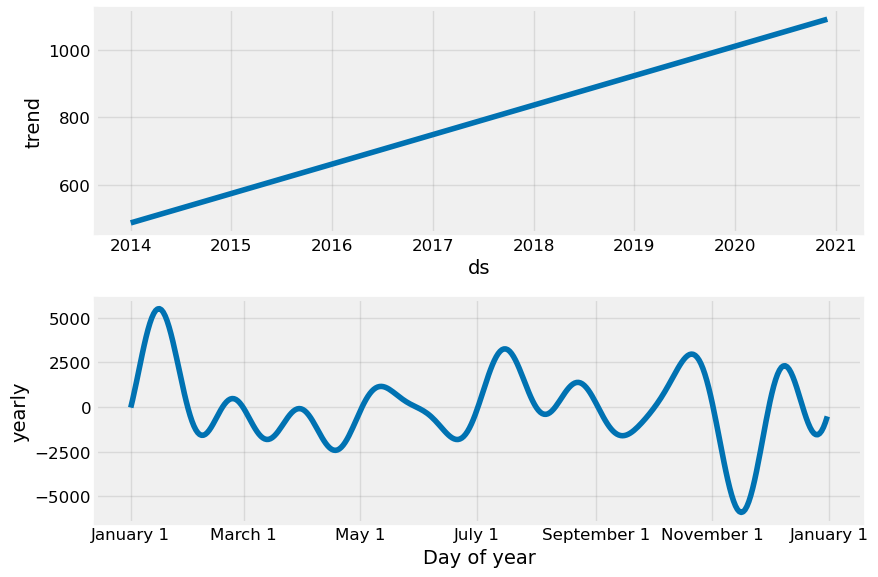

In [42]:
office_model.plot_components(office_forecast);

Good to see that the sales for both furniture and office supplies have been linearly increasing over time although office supplies' growth seems slightly stronger.

The worst month for furniture is April, the worst month for office supplies is February. The best month for furniture is December, and the best month for office supplies is November.

There are many time-series analysis we can explore from now on, such as forecast with uncertainty bounds, change point and anomaly detection, forecast time-series with external data source. We have only scratched the surface here. Stay tuned for future works on time-series analysis.